## Description
In this notebook the similarities from one word to a given word pool fo mobility words is calculated using word embeddings form BERT.

#### Result
This approach is suitable, but can be fine tuned using SBERT.

The code was created with the assistance of ChatGPT-4.

In [2]:
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import torch
import fasttext

# Load BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-german-cased")
model = AutoModel.from_pretrained("google-bert/bert-base-german-cased")

# Load fastText model
model_fasttext = fasttext.load_model('data/cc.de.300.bin')  # Path to pre-downloaded fastText binary

# Define mobility-related words
mobility_words = [
    "Verkehr", "Transport", "Fahrzeug", "Strasse", "Fahrplan", "Auto", "Autobahn", "Bahn", "Mobilität",
    "Fahrrad", "Bus", "E-Mobilität", "ÖV", "Flughafen", "Lkw", "Velo"
]

# Example words
word_true = "Autobahn"
word_false = "Apfel"

# --------- Embedding-Funktionen ---------

# Get BERT embedding using [CLS] token
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# Get fastText embedding
def get_fasttext_embedding(word):
    return model_fasttext.get_word_vector(word)

# --------- Vergleichsfunktion ---------

def analyze_embedding_model(get_embedding_fn, model_name):
    print(f"\n--- {model_name} ---")

    # Embeddings berechnen
    emb_true = get_embedding_fn(word_true)
    emb_false = get_embedding_fn(word_false)
    mobility_embs = [get_embedding_fn(w) for w in mobility_words]

    # Kosinus-Ähnlichkeiten berechnen
    sim_true = cosine_similarity([emb_true], mobility_embs)[0]
    sim_false = cosine_similarity([emb_false], mobility_embs)[0]

    # Ähnlichkeits-Wörter sortieren
    sim_dict_true = {w: s for w, s in zip(mobility_words, sim_true)}
    sim_dict_false = {w: s for w, s in zip(mobility_words, sim_false)}

    sorted_true = sorted(sim_dict_true.items(), key=lambda x: x[1], reverse=True)
    sorted_false = sorted(sim_dict_false.items(), key=lambda x: x[1], reverse=True)

    # Top 5 Scores
    top5_true = sorted_true[:5]
    top5_false = sorted_false[:5]

    avg_all_true = np.mean(sim_true)
    avg_all_false = np.mean(sim_false)

    avg_top5_true = np.mean([s for _, s in top5_true])
    avg_top5_false = np.mean([s for _, s in top5_false])

    # Ausgabe
    print(f"\nTop 5 similar mobility words to '{word_true}':")
    for w, s in top5_true:
        print(f"{w}: {s:.4f}")
    print(f"\nAverage similarity to all mobility terms: {avg_all_true:.4f}")
    print(f"Average of top 5: {avg_top5_true:.4f}")

    print(f"\nTop 5 similar mobility words to '{word_false}':")
    for w, s in top5_false:
        print(f"{w}: {s:.4f}")
    print(f"\nAverage similarity to all mobility terms: {avg_all_false:.4f}")
    print(f"Average of top 5: {avg_top5_false:.4f}")

    # Rückgabe für späteren Vergleich
    return {
        "model": model_name,
        "avg_all_true": avg_all_true,
        "avg_all_false": avg_all_false,
        "avg_top5_true": avg_top5_true,
        "avg_top5_false": avg_top5_false
    }

# --------- Analyse durchführen ---------

results = []
results.append(analyze_embedding_model(get_bert_embedding, "BERT"))
results.append(analyze_embedding_model(get_fasttext_embedding, "fastText"))

# --------- Vergleich ---------

df_results = pd.DataFrame(results)
print("\n\n--- Summary Comparison ---")
print(df_results.to_string(index=False))



--- BERT ---

Top 5 similar mobility words to 'Autobahn':
Autobahn: 1.0000
Bahn: 0.8439
Bus: 0.8335
Strasse: 0.8225
Verkehr: 0.8175

Average similarity to all mobility terms: 0.7759
Average of top 5: 0.8635

Top 5 similar mobility words to 'Apfel':
Auto: 0.7446
Velo: 0.7341
Fahrrad: 0.7274
E-Mobilität: 0.7205
Mobilität: 0.7167

Average similarity to all mobility terms: 0.6977
Average of top 5: 0.7287

--- fastText ---

Top 5 similar mobility words to 'Autobahn':
Autobahn: 1.0000
Auto: 0.5270
Strasse: 0.5218
Flughafen: 0.5142
Lkw: 0.4999

Average similarity to all mobility terms: 0.4069
Average of top 5: 0.6126

Top 5 similar mobility words to 'Apfel':
Bus: 0.3236
Fahrrad: 0.3016
Auto: 0.2876
Lkw: 0.2394
Bahn: 0.2255

Average similarity to all mobility terms: 0.1987
Average of top 5: 0.2755


--- Summary Comparison ---
   model  avg_all_true  avg_all_false  avg_top5_true  avg_top5_false
    BERT      0.775874       0.697682       0.863471        0.728656
fastText      0.406905       0.


--- BERT ---


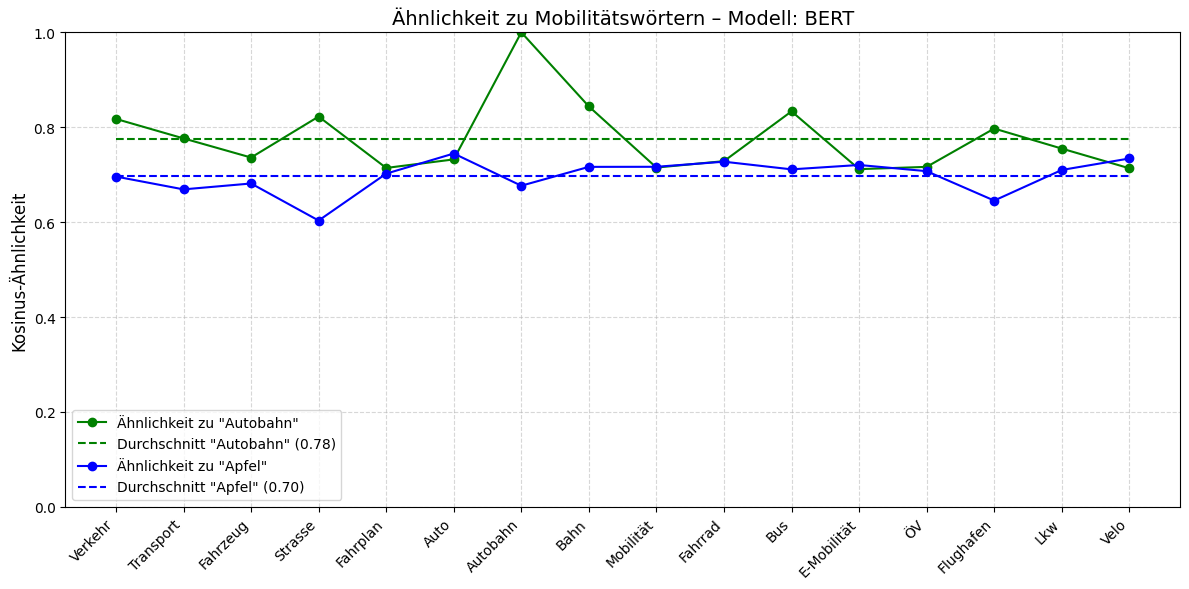


--- fastText ---


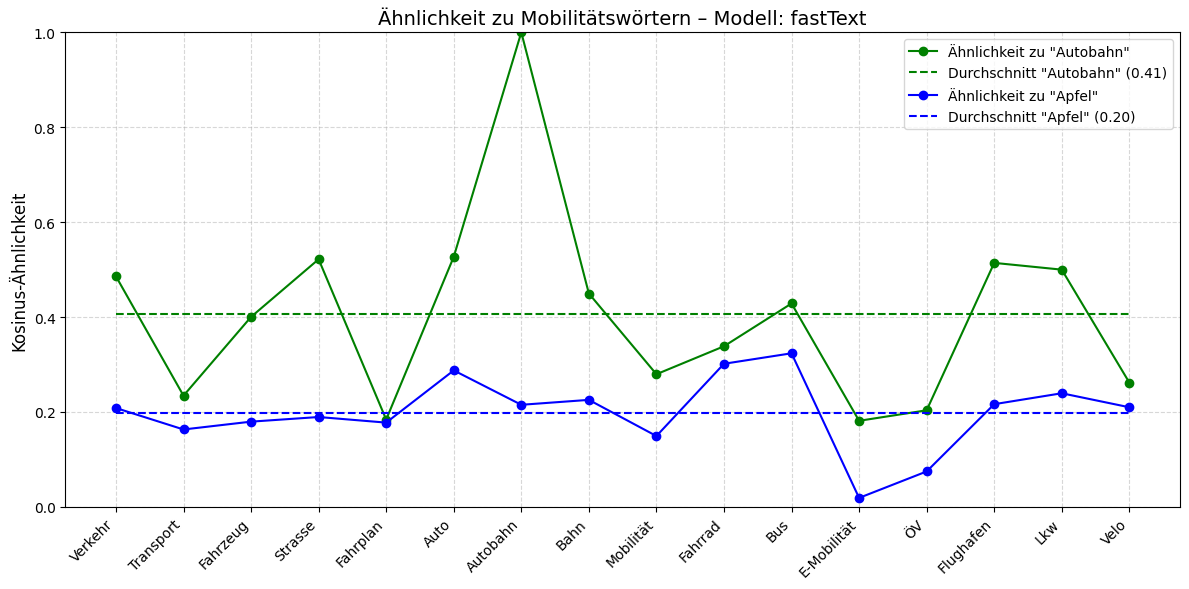



--- Summary Comparison ---
   model  avg_all_true  avg_all_false  avg_top5_true  avg_top5_false
    BERT      0.775874       0.697682       0.863471        0.728656
fastText      0.406905       0.198745       0.612572        0.275537


In [4]:
import matplotlib.pyplot as plt
from matplotlib import ticker

# Funktion für das Plotten
def plot_similarity_scores(sim_true, sim_false, model_name):
    x_pos = np.arange(len(mobility_words))

    plt.figure(figsize=(12, 6))

    # Plot True
    plt.plot(x_pos, sim_true, 'o-', label=f'Ähnlichkeit zu \"{word_true}\"', color='green')
    plt.hlines(np.mean(sim_true), x_pos[0], x_pos[-1], colors='green', linestyles='dashed', 
               label=f'Durchschnitt \"{word_true}\" ({np.mean(sim_true):.2f})')

    # Plot False
    plt.plot(x_pos, sim_false, 'o-', label=f'Ähnlichkeit zu \"{word_false}\"', color='blue')
    plt.hlines(np.mean(sim_false), x_pos[0], x_pos[-1], colors='blue', linestyles='dashed', 
               label=f'Durchschnitt \"{word_false}\" ({np.mean(sim_false):.2f})')

    # Wörter als xticks
    plt.xticks(x_pos, mobility_words, rotation=45, ha='right', fontsize=10)
    plt.ylim(0, 1)
    plt.ylabel("Kosinus-Ähnlichkeit", fontsize=12)
    plt.title(f"Ähnlichkeit zu Mobilitätswörtern – Modell: {model_name}", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Analyse mit Plot erweitern
def analyze_embedding_model_with_plot(get_embedding_fn, model_name):
    print(f"\n--- {model_name} ---")

    emb_true = get_embedding_fn(word_true)
    emb_false = get_embedding_fn(word_false)
    mobility_embs = [get_embedding_fn(w) for w in mobility_words]

    sim_true = cosine_similarity([emb_true], mobility_embs)[0]
    sim_false = cosine_similarity([emb_false], mobility_embs)[0]

    plot_similarity_scores(sim_true, sim_false, model_name)

    return {
        "model": model_name,
        "avg_all_true": np.mean(sim_true),
        "avg_all_false": np.mean(sim_false),
        "avg_top5_true": np.mean(sorted(sim_true, reverse=True)[:5]),
        "avg_top5_false": np.mean(sorted(sim_false, reverse=True)[:5])
    }

# Neu ausgeführte Analyse mit Plot
results = []
results.append(analyze_embedding_model_with_plot(get_bert_embedding, "BERT"))
results.append(analyze_embedding_model_with_plot(get_fasttext_embedding, "fastText"))

# Vergleich zusammenfassen
df_results = pd.DataFrame(results)
print("\n\n--- Summary Comparison ---")
print(df_results.to_string(index=False))


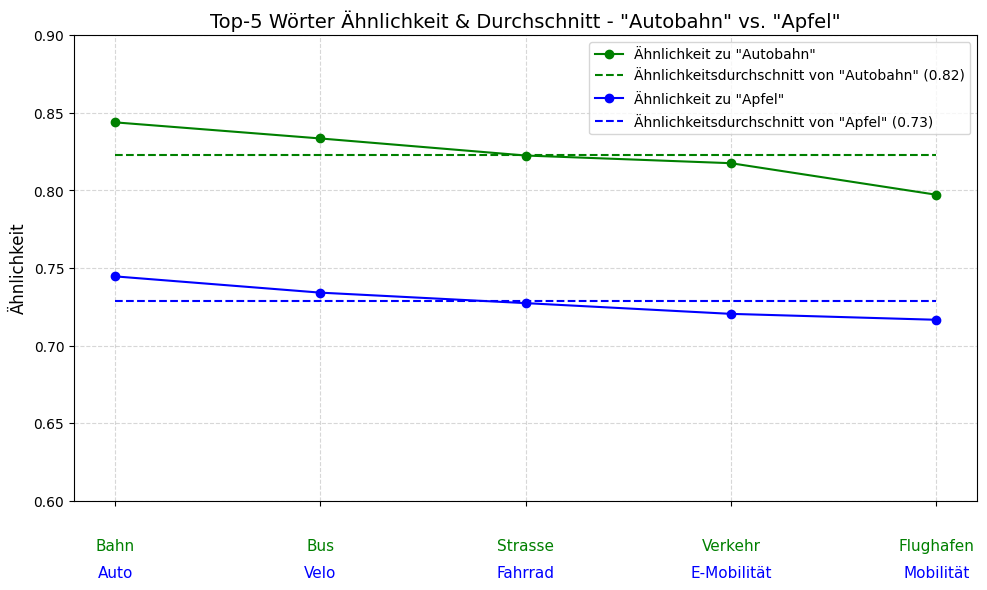

In [8]:
import matplotlib.pyplot as plt
from matplotlib import ticker

plt.figure(figsize=(10, 6))
x_pos = range(5)

# Plot True scores
plt.plot(x_pos, top_5_scores_true, 'o-', label=f'Ähnlichkeit zu \"{word_true}\"', color='green')
plt.hlines(top_5_average_score_true, x_pos[0], x_pos[-1], colors='green', linestyles='dashed', label=f'Ähnlichkeitsdurchschnitt von \"{word_true}\" ({round(top_5_average_score_true, 2)})')

# Plot False scores
plt.plot(x_pos, top_5_scores_false, 'o-', label=f'Ähnlichkeit zu \"{word_false}\"', color='blue')
plt.hlines(top_5_average_score_false, x_pos[0], x_pos[-1], colors='blue', linestyles='dashed', label=f'Ähnlichkeitsdurchschnitt von \"{word_false}\" ({round(top_5_average_score_false, 2)})')

# Set empty x-ticks, then manually place colored text
plt.xticks(x_pos, [""] * 5)
ax = plt.gca()

for i, (w_true, w_false) in enumerate(zip(top_5_words_true, top_5_words_false)):
    ax.text(i, -0.08, w_true, ha='center', va='top', color='green', fontsize=11, transform=ax.get_xaxis_transform())
    ax.text(i, -0.17, w_false, ha='center', va='bottom', color='blue', fontsize=11, transform=ax.get_xaxis_transform())

# Styling
plt.ylim(0.6, 0.9)
plt.ylabel("Ähnlichkeit", fontsize=12)
plt.title(f"Top-5 Wörter Ähnlichkeit & Durchschnitt - \"{word_true}\" vs. \"{word_false}\"", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


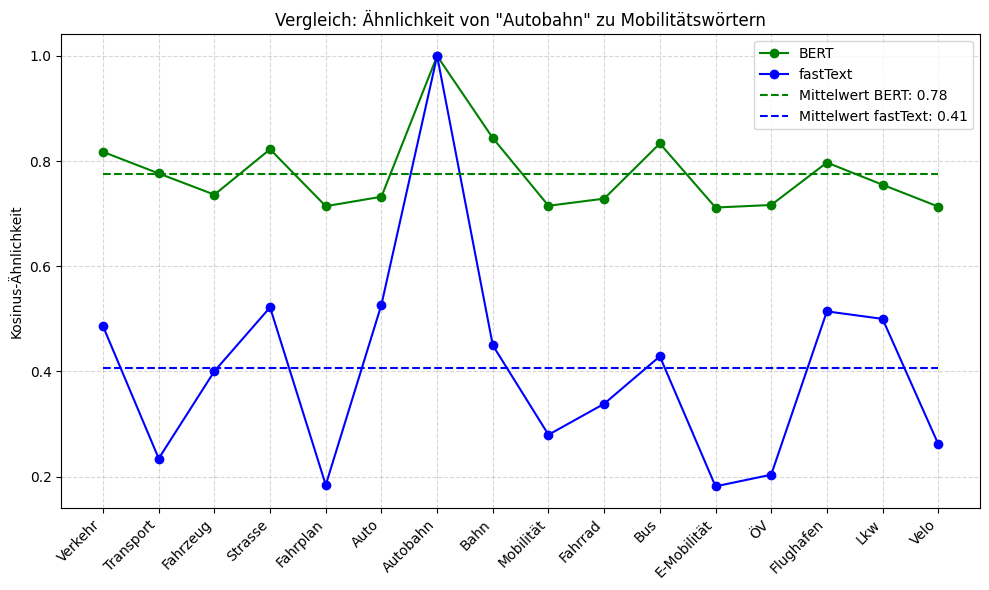

In [5]:
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import fasttext
import torch

# Modelle laden
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-german-cased")
model_bert = AutoModel.from_pretrained("google-bert/bert-base-german-cased")
model_fasttext = fasttext.load_model('data/cc.de.300.bin')

# Wortlisten
mobility_words = [
    "Verkehr", "Transport", "Fahrzeug", "Strasse", "Fahrplan", "Auto", "Autobahn", "Bahn", "Mobilität",
    "Fahrrad", "Bus", "E-Mobilität", "ÖV", "Flughafen", "Lkw", "Velo"
]
word = "Autobahn"

# Einbettungsfunktionen
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model_bert(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

def get_fasttext_embedding(word):
    return model_fasttext.get_word_vector(word)

# Ähnlichkeiten berechnen
def get_similarities(embedding_fn):
    emb_target = embedding_fn(word)
    emb_mobility = [embedding_fn(w) for w in mobility_words]
    sims = cosine_similarity([emb_target], emb_mobility)[0]
    return sims

sims_bert = get_similarities(get_bert_embedding)
sims_fasttext = get_similarities(get_fasttext_embedding)

# Durchschnitt berechnen
avg_bert = np.mean(sims_bert)
avg_fasttext = np.mean(sims_fasttext)

# Plot
plt.figure(figsize=(10, 6))
x = np.arange(len(mobility_words))
plt.plot(x, sims_bert, 'o-', label='BERT', color='green')
plt.plot(x, sims_fasttext, 'o-', label='fastText', color='blue')
plt.hlines(avg_bert, x[0], x[-1], colors='green', linestyles='dashed', label=f'Mittelwert BERT: {avg_bert:.2f}')
plt.hlines(avg_fasttext, x[0], x[-1], colors='blue', linestyles='dashed', label=f'Mittelwert fastText: {avg_fasttext:.2f}')
plt.xticks(x, mobility_words, rotation=45, ha='right')
plt.ylabel("Kosinus-Ähnlichkeit")
plt.title(f"Vergleich: Ähnlichkeit von \"{word}\" zu Mobilitätswörtern")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
